# This is my final Capstone project: Compare the neighborhoods of New York and Toranto based on K-Means Methode

## Introduction

New York City and Toronto are very diverse and are the financial capitals of their respective countries.

My friend Mr. Wang works in Toronto and lives in a very good neighborhood. There are many popular venues around this neighborhood, but now he has a chance to work in New York, he hopes to find a neighborhood in New York that is very similar to the neighborhood in Toronto.

This Project uesd the data from internet to compare the neighborhoods of the two cities(New York City and Toronto) and determine how similar or dissimilar they are, meanwhile provide a solution for the users who are also interested in the features of neighborhoods in different cities.

## Import Libraries

In [363]:
from bs4 import BeautifulSoup
import numpy as np # library to handle data in a vectorized manner
import requests
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from sklearn.cluster import KMeans
import folium # map rendering library
from sklearn import metrics 
from scipy.spatial.distance import cdist 
import matplotlib.pyplot as plt
print('Libraries imported.')

Libraries imported.


## Import Data of Toronto
#### Creat dataframe and obtain the table from website

In [364]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
res = requests.get(url)
soup = BeautifulSoup(res.text, 'lxml')
tables = soup.select('table')[0]
df_1 = pd.read_html(tables.prettify(),header = 0)[0]
df_1.to_csv('Neighborhoodtable_Toronto.csv')

In [365]:
df_1.head()

,Postal code,Borough,Neighborhood
0,M1A,Not assigned,NaN
1,M2A,Not assigned,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront


In [366]:
df = df.dropna(axis = 0)
df.to_csv('data.csv')
df.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park , Harbourfront"
3,M6A,North York,"Lawrence Manor , Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government"


In [367]:
df['Neighborhood']=df['Neighborhood'].str.replace('/',',')
df.index = range(len(df))

In [369]:
df.rename(columns={"Postal code": "Postal Code"},inplace = True)

In [370]:
df.shape

(103, 3)

#### Merge two tables

In [371]:
geo = pd.read_csv('Geospatial_Coordinates.csv')
toronto_neighborhoods = pd.merge(df,geo, on = 'Postal Code')

In [372]:
toronto_neighborhoods.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494


In [373]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df2['Borough'].unique()),
        df2.shape[0]
    )
)

The dataframe has 10 boroughs and 103 neighborhoods.


In [374]:
address_t = 'Toronto'

geolocator_t = Nominatim(user_agent="ny_explorer")
location_t = geolocator_t.geocode(address_t)
latitude_t = location_t.latitude
longitude_t = location_t.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude_t, longitude_t))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [375]:
map_toronto = folium.Map(location=[latitude_t, longitude_t], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df2['Latitude'], df2['Longitude'], df2['Borough'], df2['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### Get the geojson file, which I have already downloaded.

In [376]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [377]:
newyork_neighborhoods_data = newyork_data['features']

In [378]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
newyork_neighborhoods = pd.DataFrame(columns=column_names)

In [379]:
newyork_neighborhoods

,Borough,Neighborhood,Latitude,Longitude


#### Put the geojson data to the dataframe

In [380]:
for data in newyork_neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    newyork_neighborhoods = newyork_neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [381]:
newyork_neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [382]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(newyork_neighborhoods['Borough'].unique()),
        newyork_neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


### Use geopy library to get the latitude and longitude values of New York City.

In [383]:
address_n = 'New York, NY'

geolocator_n = Nominatim(user_agent="ny_explorer")
location_n = geolocator_n.geocode(address_n)
latitude_n = location_n.latitude
longitude_n = location_n.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude_n, longitude_n))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


### Use folium library to creat map of New York

In [384]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude_n, longitude_n], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(newyork_neighborhoods['Latitude'], newyork_neighborhoods['Longitude'], newyork_neighborhoods['Borough'], newyork_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

### Merge all the Neighborhoods from New York City and Toranto, they should be 409 rows

In [385]:
toronto_neighborhoods.drop('Postal Code',axis = 1,inplace = True)
toronto_neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,North York,Parkwoods,43.753259,-79.329656
1,North York,Victoria Village,43.725882,-79.315572
2,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636
3,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763
4,Downtown Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494


In [386]:
newyork_neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


#### concat the dataframes and reset the index

In [387]:
frames = [toronto_neighborhoods,newyork_neighborhoods]
neighborhoods = pd.concat(frames)
neighborhoods.sort_values(by = 'Borough',inplace = True)
neighborhoods.index = range(len(neighborhoods))
neighborhoods.shape

(409, 4)

#### Create a function to explore all the neighborhoods
#### At first set the client ID

In [388]:
CLIENT_ID = 'BRLE5DUTP4HBYL2PHQUYFRBIXIS0WXH2ZBGH4GON11B0KOKT' # your Foursquare ID
CLIENT_SECRET = 'C2KVY3KCA1SOCDMU1VS20JPI30HXMZE0BTACZSURYTWOTPYX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: BRLE5DUTP4HBYL2PHQUYFRBIXIS0WXH2ZBGH4GON11B0KOKT
CLIENT_SECRET:C2KVY3KCA1SOCDMU1VS20JPI30HXMZE0BTACZSURYTWOTPYX


In [389]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now get the data from the API

In [390]:
neighborhoods_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Fieldston
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Port Morris
Parkchester
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Westchester Square
Mott Haven
Melrose
High  Bridge
Wakefield
Co-op City
Eastchester
Riverdale
Kingsbridge
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
Edgewater Park
Olinville
Castle Hill
Concourse Village
Claremont Village
Mount Eden
Mount Hope
Pelham Gardens
Concourse
Unionport
Edenwald
Bronxdale
Allerton
Kingsbridge Heights
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Cypress Hills
Park Slope
Cobble Hill
Coney Island
East New York
Starrett City
Canarsie
Bath Beach
Manhattan Beach
Brooklyn Heights
Brownsville
Bushwick
Borough Park
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Bedford Stuyvesant
Sheepshead Bay
Flatbush
Crown Heights
East Flatbush
Kensington
Windso

#### check the size of the resulting dataframe

In [391]:
print(neighborhoods_venues.shape)

(12317, 7)


In [392]:
neighborhoods_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Fieldston,40.895437,-73.905643,Fieldston Road Circle,40.894489,-73.905621,Plaza
1,Fieldston,40.895437,-73.905643,nicksemlerSPA,40.894942,-73.905475,Spa
2,Fieldston,40.895437,-73.905643,Riverside Drive,40.896507,-73.908261,River
3,Fieldston,40.895437,-73.905643,MTA MaBSTOA Bus Bx7 / Bx10 / Bx20 / BxM1 / BxM...,40.893548,-73.908151,Bus Station
4,Longwood,40.815099,-73.895788,Di-Elle's Restaurant,40.817116,-73.896429,Diner


#### check how many venues were returned for each neighborhood

In [393]:
neighborhoods_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,5,5,5,5,5,5
"Alderwood , Long Branch",10,10,10,10,10,10
Allerton,32,32,32,32,32,32
Annadale,13,13,13,13,13,13
Arden Heights,5,5,5,5,5,5
Arlington,4,4,4,4,4,4
Arrochar,19,19,19,19,19,19
Arverne,18,18,18,18,18,18
Astoria,100,100,100,100,100,100


#### find out how many unique categories can be curated from all the returned venues

In [394]:
print('There are {} uniques categories.'.format(len(neighborhoods_venues['Venue Category'].unique())))

There are 457 uniques categories.


## Analyze Each Neighborhood

In [395]:
# one hot encoding
df_onehot = pd.get_dummies(neighborhoods_venues[['Venue Category']], prefix="", prefix_sep="")

In [396]:
# drop the column'Neighborhood', cause We will add a new column named 'Neighborhood'
df_onehot.drop(columns = 'Neighborhood',inplace = True)
df_onehot.head()

,Accessories Store,Acupuncturist,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Basketball Court,College Bookstore,College Cafeteria,College Gym,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,

In [397]:
df_onehot['Neighborhood'] = neighborhoods_venues['Neighborhood']
fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
df_onehot = df_onehot[fixed_columns]

In [398]:
df_onehot.head()

,Neighborhood,Accessories Store,Acupuncturist,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Basketball Court,College Bookstore,College Cafeteria,College Gym,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern Europea

In [399]:
print(df_onehot.shape)

(12317, 457)


### group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [400]:
df_grouped = df_onehot.groupby('Neighborhood').mean().reset_index()
df_grouped.head()

,Neighborhood,Accessories Store,Acupuncturist,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Basketball Court,College Bookstore,College Cafeteria,College Gym,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern Europea

In [401]:
df_grouped.shape

(395, 457)

### create the new dataframe and display the top 10 venues for each neighborhood.

In [402]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [329]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = df_grouped['Neighborhood']

for ind in np.arange(df_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Latin American Restaurant,Skating Rink,Clothing Store,Breakfast Spot,Cuban Restaurant,Fabric Shop,Eastern European Restaurant,Egyptian Restaurant,Cosmetics Shop
1,"Alderwood , Long Branch",Pizza Place,Coffee Shop,Dance Studio,Pub,Skating Rink,Gym,Sandwich Place,Pool,Pharmacy,Entertainment Service
2,Allerton,Pizza Place,Chinese Restaurant,Supermarket,Deli / Bodega,Department Store,Food,Dessert Shop,Bakery,Gas Station,Grocery Store
3,Annadale,Pizza Place,Bakery,American Restaurant,Restaurant,Pharmacy,Train Station,Diner,Dance Studio,Food,Sports Bar
4,Arden Heights,Bus Stop,Pizza Place,Pharmacy,Deli / Bodega,Coffee Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant


## Cluster Neighborhoods

In [330]:
df_grouped_clustering = df_grouped.drop('Neighborhood', 1)

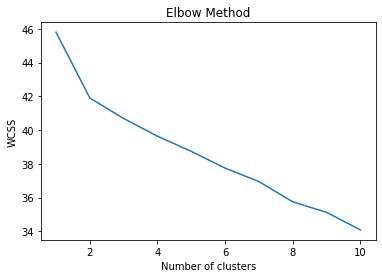

In [331]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_grouped_clustering)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [332]:
kclusters = 6

# run k-means clustering
kmeans = KMeans(init = "random",n_clusters=kclusters, random_state=0).fit(df_grouped_clustering)
k_means_labels = kmeans.labels_
# check cluster labels generated for each row in the dataframe
k_means_labels

array([4, 5, 0, 5, 5, 2, 2, 0, 4, 0, 0, 0, 0, 4, 4, 0, 0, 4, 3, 0, 0, 4,
       4, 0, 2, 0, 0, 0, 0, 4, 0, 4, 4, 2, 4, 5, 4, 4, 0, 5, 0, 4, 0, 4,
       2, 0, 0, 4, 4, 4, 4, 3, 0, 4, 0, 4, 4, 5, 5, 0, 4, 4, 4, 4, 4, 4,
       4, 4, 0, 4, 0, 0, 3, 4, 0, 4, 0, 0, 4, 0, 4, 4, 0, 0, 4, 0, 0, 5,
       0, 4, 4, 0, 0, 4, 5, 0, 0, 0, 4, 0, 4, 4, 0, 0, 0, 0, 3, 5, 4, 4,
       0, 0, 5, 4, 4, 2, 0, 0, 4, 0, 5, 4, 0, 4, 4, 4, 0, 4, 0, 5, 4, 0,
       4, 0, 0, 4, 0, 2, 0, 4, 4, 0, 4, 0, 5, 5, 4, 4, 4, 0, 0, 2, 0, 5,
       4, 5, 4, 2, 0, 4, 4, 4, 4, 0, 4, 0, 0, 4, 0, 0, 0, 0, 4, 0, 5, 4,
       4, 4, 0, 0, 0, 0, 0, 4, 0, 4, 0, 4, 0, 0, 0, 5, 5, 0, 4, 3, 4, 0,
       4, 4, 4, 0, 4, 0, 4, 4, 0, 4, 2, 4, 0, 2, 5, 4, 4, 0, 0, 0, 2, 0,
       5, 0, 4, 4, 4, 5, 0, 1, 3, 0, 2, 4, 0, 5, 0, 0, 0, 0, 4, 4, 2, 0,
       2, 0, 0, 4, 4, 0, 4, 5, 4, 4, 4, 4, 5, 0, 4, 2, 0, 1, 0, 0, 0, 4,
       2, 4, 0, 4, 5, 3, 0, 0, 0, 0, 4, 0, 5, 5, 4, 0, 0, 4, 0, 0, 4, 2,
       0, 4, 4, 0, 0, 4, 0, 4, 0, 0, 4, 0, 4, 0, 4,

#### create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [333]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', k_means_labels)
df_merged = neighborhoods
df_merged = neighborhoods_venues_sorted.join(df_merged.set_index('Neighborhood'), on='Neighborhood')

In [334]:
df_merged.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Borough,Latitude,Longitude
0,4,Agincourt,Lounge,Latin American Restaurant,Skating Rink,Clothing Store,Breakfast Spot,Cuban Restaurant,Fabric Shop,Eastern European Restaurant,Egyptian Restaurant,Cosmetics Shop,Scarborough,43.794200,-79.262029
1,5,"Alderwood , Long Branch",Pizza Place,Coffee Shop,Dance Studio,Pub,Skating Rink,Gym,Sandwich Place,Pool,Pharmacy,Entertainment Service,Etobicoke,43.602414,-79.543484
2,0,Allerton,Pizza Place,Chinese Restaurant,Supermarket,Deli / Bodega,Department Store,Food,Dessert Shop,Bakery,Gas Station,Grocery Store,Bronx,40.865788,-73.859319
3,5,Annadale,Pizza Place,Bakery,American Restaurant,Restaurant,Pharmacy,Train Station,Diner,Dance Studio,Food,Sports Bar,Staten Island,40.538114,-74.178549
4,5,Arden Heights,Bus Stop,Pizza Place,Pharmacy,Deli / Bodega,Coffee Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Staten Island,40.549286,-74.185887


### visualize the resulting clusters

In [335]:
# create map in New York
map_clusters_newyork = folium.Map(location=[latitude_n, longitude_n], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Neighborhood'], df_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_newyork)
       
map_clusters_newyork

In [336]:
# create map in Toronto
map_clusters_toronto = folium.Map(location=[latitude_t, longitude_t], zoom_start=10)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Neighborhood'], df_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_toronto)
       
map_clusters_toronto